In [12]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.v2 as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Optimizer
from torchsummary import summary
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torchshow as ts
from torch.optim import Adam

In [13]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import PIL.Image as PILImage
import os

class LungDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = PILImage.open(img_path).convert("RGB")
        mask = PILImage.open(mask_path)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = LungDataset('data/train_images', 'data/train_lung_masks', transform=transform)

dataset_size = len(train_dataset)


test_size = int(dataset_size * 0.2) 

train_size = dataset_size - test_size

train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

In [14]:
def imshow(tensor):
    image = transforms.ToPILImage()(tensor).convert("RGB")
    plt.imshow(image)
    plt.show()

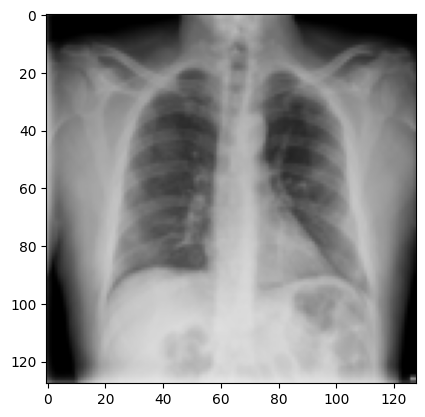

In [15]:
imshow(train_dataset[0][0])

In [16]:
import torch
from torch import nn

def double_conv(in_channels, out_channels, dropout=0.0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout)
    )   

class UNet_copy(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64, dropout=0.1)
        self.dconv_down2 = double_conv(64, 128, dropout=0.2)
        self.dconv_down3 = double_conv(128, 256, dropout=0.3)
        self.dconv_down4 = double_conv(256, 512, dropout=0.4)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256, dropout=0.3)
        self.dconv_up2 = double_conv(128 + 256, 128, dropout=0.2)
        self.dconv_up1 = double_conv(128 + 64, 64, dropout=0.1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


In [17]:
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = UNet_copy(1).to(device)

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
           Dropout-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
              ReLU-5         [-1, 64, 128, 128]               0
           Dropout-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
              ReLU-9          [-1, 128, 64, 64]               0
          Dropout-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
             ReLU-12          [-1, 128, 64, 64]               0
          Dropout-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
from tqdm import tqdm
import torchvision
from torchvision.transforms import ToPILImage
from IPython.display import Image

def run_epoch(model, opt, loss, dataloader, is_train=True):
    model.train(is_train)
    total_loss = 0.0
    with torch.set_grad_enabled(is_train):
        for x, y_true in tqdm(dataloader):
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred = model(x) 
            l = loss(y_pred, y_true)
            if (is_train):
                opt.zero_grad()
                l.backward()
                opt.step()
            total_loss += l.item()
    return total_loss / len(dataloader.dataset)

def plot_loss(loss, title, num_epochs, color):
    plt.title(title)
    plt.plot(loss, color=color)
    plt.grid()
    plt.xticks(np.arange(num_epochs))

def plot_losses(train, val, num_epochs):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plot_loss(train, f'Train Loss = {train[-1]}', num_epochs, color='blue')
    plt.subplot(1, 2, 2)
    plot_loss(val, f'Val Loss = {val[-1]}', num_epochs, color='orange')
    plt.show()
    
def show_examples(model, dataset, size):
    model.eval()
    with torch.no_grad():
        idxs = np.random.randint(0, len(dataset), size)
        x = torch.stack([dataset[i][0] for i in idxs]).to(device)
        y_true = torch.stack([dataset[i][1] for i in idxs]).to(device)
        y_pred = model(x)
        print("Original images")
        grid_img = torchvision.utils.make_grid(x.cpu(), nrow=8)
        img = ToPILImage()(grid_img)
        display(img)
        print("True masks")
        grid_img = torchvision.utils.make_grid(y_true.cpu(), nrow=8)
        img = ToPILImage()(grid_img)
        display(img)
        print("Predicted masks")
        grid_img = torchvision.utils.make_grid(y_pred.cpu(), nrow=8)
        img = ToPILImage()(grid_img)
        display(img)
        
from IPython.display import clear_output

def run_train_loop(model, opt, loss, train_loader, val_loader, num_epochs, ex_size):
    train_hist = []
    val_hist = []
    for e in range(num_epochs):
        print("Training...")
        train_loss = run_epoch(model, opt, loss, train_loader)
        train_hist.append(train_loss)
        print("Validating...")
        val_loss = run_epoch(model, opt, loss, val_loader, is_train=False)
        val_hist.append(val_loss)
        clear_output()
        plot_losses(train_hist, val_hist, num_epochs)
        show_examples(model, val_loader.dataset, ex_size)


In [20]:
batch_size = 64
num_epochs = 50
ex_size = 8


sae = UNet_copy(1).to(device)
sae_opt = Adam(model.parameters(), lr=0.001, weight_decay=0.01)
sae_loss = nn.MSELoss(reduction='sum')

run_train_loop(sae, sae_opt, sae_loss,
               train_loader, test_loader, num_epochs, ex_size)

Training...


  3%|▎         | 5/169 [04:42<2:34:25, 56.50s/it]


KeyboardInterrupt: 